In [0]:

#@title
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
import numpy as np
from sklearn.metrics import roc_curve, auc, average_precision_score
import random
random.seed(1234)
import gzip # unzip gz files
import pandas as pd 
import matplotlib.pyplot as plt



def getFASTAfromGZ(gz_file):
  """
  Helper function: converts gzipped sequence files (FASTA) 
  into an array of strings of sequences.
  """
  fastas = []
  seq = None
  header = None
  for r in gzip.open(gz_file):
      if type(r) is bytes:
          r = r.decode("utf-8")
      r = r.strip()
      if r.startswith(">"):
          if seq != None and header != None:
              fastas.append([header, seq])
          seq = ""
          header = r[1:]
      else: seq += r.upper()
  fastas.append([header, seq])
  return pd.DataFrame({'location': [e[0] for e in fastas], 'sequence': [e[1] for e in fastas]})

In [2]:
#@title
# downloads data needed for this tutorial
!wget https://github.com/const-ae/Neural_Network_DNA_Demo/raw/master/data/pu1.fa.gz

--2020-04-26 15:56:30--  https://github.com/const-ae/Neural_Network_DNA_Demo/raw/master/data/pu1.fa.gz
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/const-ae/Neural_Network_DNA_Demo/master/data/pu1.fa.gz [following]
--2020-04-26 15:56:30--  https://raw.githubusercontent.com/const-ae/Neural_Network_DNA_Demo/master/data/pu1.fa.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1307470 (1.2M) [application/octet-stream]
Saving to: ‘pu1.fa.gz’

pu1.fa.gz           100%[===================>]   1.25M  --.-KB/s    in 0.01s   

2020-04-26 15:56:30 (115 MB/s) - ‘pu1.fa.gz’ saved [1307470/1307470]



## Using Deep Learning for Sequence Prediction Tasks

In this notebook, you will train for yourself a model (for example, a neural network) on DNA sequence data, that can predict transcription factor binding sites! You'll get to see some pretty pictures at the end, provided you get a model working. 

In [0]:
def encode_one_hot(sequence, length):
  """
  You should write a function that converts the pandas array from getFASTAfromGZ (see below)
  into an np.array X of shape (number of sequences, sequence length, 4), where for each sequence
  i between 0 and number of sequences - 1, the (sequence length, 4)-numpy array X[i] is one-hot encoded. 
  What does this mean? Let's see an example. 
  Suppose that sequence[i] is "ACGAT". If we decide to map A->0, C->1, T->2, G->3, then we have:
  
  sequence[i] is "ACGAT"
  X[i] is [[1, 0, 0, 0]
           [0, 1, 0, 0]
           [0, 0, 0, 1]
           [1, 0, 0, 0]
           [0, 0, 1, 0]]
  """
  allSeq = np.zeros((len(sequence), len(sequence[0]), 4))
  for i in range(len(sequence)):
    for j in range(len(sequence[i])):
      if sequence[i][j] == 'A':
        allSeq[i, j, 0] = 1
      elif sequence[i][j] == 'C':
        allSeq[i, j, 1] = 1
      elif sequence[i][j] == 'T':
        allSeq[i, j, 2] = 1
      elif sequence[i][j] == 'G':
        allSeq[i, j, 3] = 1  
  # Fill in code here
  X = allSeq
  return X

In [0]:
## DON'T CHANGE: If you implemented encode_one_hot correctly above, then this code should just work without any modification
input_FASTA = getFASTAfromGZ("pu1.fa.gz") # note that input_FASTA.sequence is the "sequence" parameter of encode_one_hot.
seq_matrices = encode_one_hot(input_FASTA.sequence, len(input_FASTA.sequence[0]))

In [0]:
## DON'T CHANGE: This function jumbles up the sequences to create negative examples
def shuffle_sequences(X):
    x_shuffled = X
    for x in range(0, x_shuffled.shape[0]):
        random_index = np.arange(0, int(X.shape[1]/2))
        np.random.shuffle(random_index)
        for y in range(0, int(X.shape[1]/2)):
            x_shuffled[x,y*2, ] = X[int(x%X.shape[0]),random_index[y]*2]
            x_shuffled[x,(y*2)+1, ] = X[int(x%X.shape[0]),(random_index[y]*2)+1]
    return x_shuffled

In [0]:
## DON'T CHANGE: These lines of code shuffle the data in input_FASTA to create negative examples. These should all work if encode_one_hot does.
seq_shuffled = shuffle_sequences(np.array([[[e] for e in list(x)] for x in input_FASTA.sequence]))
seq_shuffled = np.array(["".join(seq_shuffled[x, :, 0]) for x in range(seq_shuffled.shape[0])])
seq_matrices_shuffled = encode_one_hot(seq_shuffled, len(seq_shuffled[0]))

**Models**

In [0]:
## TODO: make this better! (see instructions below.)
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Input, concatenate
def get_keras_model(input_shape=(100, 4)):
  """
  You should write a function here that uses the input shape to 
  give a Keras model. Do not compile your model or fit it here.
  The input size for the first layer is provided as an argument above. 
  An example model is given below. It doesn't do so well. You can import
  any additional tf.keras.layers you need. 
  """
  inputs = Input(shape=input_shape)
  conv1 = Conv1D(filters=40, kernel_size=10)(inputs)
  maxPool1 = MaxPooling1D(pool_size=3, strides=None)(conv1)
  conv2 = Conv1D(filters=80, kernel_size=5)(maxPool1)
  maxPool2 = MaxPooling1D(pool_size=5, strides=None)(conv2)
  x = Flatten()(maxPool2)
  output = Dense(16, activation='relu')(x)
  predictions = Dense(1, activation='sigmoid')(output)
  model = tf.keras.Model(inputs=inputs, outputs=predictions)
  return model

In [20]:
model = get_keras_model()
model.compile(loss='binary_crossentropy', optimizer='sgd') # for ease, we assume for now that mean square error is the loss, and SGD is the optimizer. 
model.summary() 

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 4)]          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 91, 40)            1640      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 30, 40)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 26, 80)            16080     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 5, 80)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                6416

**Formatting data for Keras**

We need to split the data we have into a test and train set, and also ensure that our examples are (100, 4, 1).

In [21]:
# Concatenation
X_one = np.round(np.random.random((500, 4)))
X_two = np.round(np.random.random((500, 4)))
X_master = np.concatenate((X_one, X_two), axis=0)
X_master.shape

(1000, 4)

In [0]:
# Test/Train split
from sklearn.model_selection import train_test_split
def construct_train_test_set(pos_examples, neg_examples, split=0.8):
  """
  You need to write a function that gives the labels 1 and 0 for the positive 
  and negative examples, and splits the entire dataset (pos and neg examples combined)
  into a train test of size split*num_data and test set of size (1 - split) * num_data 
  (you'll of course have to round those do integers...). Oh, and make sure that the shape of 
  the returned data adheres to the shape of the input layer, i.e., the last size arguments 
  should be 100, 4, 1. 
  """
  # Construct train test split here
  features = np.concatenate((pos_examples, neg_examples), axis=0)
  pos_labels = np.zeros(len(pos_examples))
  neg_labels = np.ones(len(neg_examples))
  labels = np.concatenate((pos_labels, neg_labels), axis=0)
  X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=(1-split))
  return X_train, X_test, Y_train, Y_test


In [0]:
# DO NOT CHANGE THIS (it should work if your function above is correct.) 
# UNCOMMENT ONCE IMPLEMENTED ABOVE.
X_train, X_test, Y_train, Y_test = construct_train_test_set(seq_matrices, seq_matrices_shuffled, split=0.8)

**Model fitting and evaluation**
You should not have to change any of this, provided your stuff above works. 

In [24]:
# do not change. 
model.fit(X_train, Y_train, batch_size=10, epochs=25, validation_data=(X_test, Y_test))

Epoch 1/25
4589/4589 [==============================] - 13s 3ms/step - loss: 0.5671 - val_loss: 0.3388
Epoch 2/25
4589/4589 [==============================] - 13s 3ms/step - loss: 0.2961 - val_loss: 0.2676
Epoch 3/25
4589/4589 [==============================] - 13s 3ms/step - loss: 0.2204 - val_loss: 0.2023
Epoch 4/25
4589/4589 [==============================] - 13s 3ms/step - loss: 0.1847 - val_loss: 0.1869
Epoch 5/25
4589/4589 [==============================] - 13s 3ms/step - loss: 0.1606 - val_loss: 0.2588
Epoch 6/25
4589/4589 [==============================] - 12s 3ms/step - loss: 0.1416 - val_loss: 0.1748
Epoch 7/25
4589/4589 [==============================] - 13s 3ms/step - loss: 0.1274 - val_loss: 0.1801
Epoch 8/25
4589/4589 [==============================] - 13s 3ms/step - loss: 0.1129 - val_loss: 0.1925
Epoch 9/25
4589/4589 [==============================] - 13s 3ms/step - loss: 0.1011 - val_loss: 0.1750
Epoch 10/25
4589/4589 [==============================] - 13s 3ms/step - l

### The code below constructs ROC curves, AUROC, AUPRC for you -- you're welcome!

In [25]:
## DO NOT CHANGE.
Y_hat = model.predict(X_test, batch_size=32).flatten()
print("Predictions", Y_hat[0:5])
fpr, tpr, thresholds = roc_curve(Y_test, Y_hat)
print("AUC", auc(fpr, tpr))
print("AUPRC", average_precision_score(Y_test, Y_hat))

Predictions [1.         0.17825948 0.5694679  1.         0.9999987 ]
AUC 0.980420370883441
AUPRC 0.9790742191959633


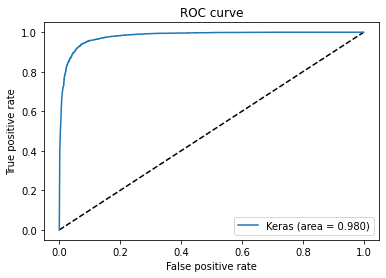

In [26]:
## DO NOT CHANGE
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Visualizing model outputs

You do not have to change any of this code.

In [0]:
def predictor(X):
  return model.predict(X, batch_size=32).flatten()

def output_scores(X, Y, pred_fn=predictor):
  # Generate a new set of X where for each sequence every nucleotide is consecutively set to 0
  tmp = np.repeat(X, 100, axis=0)
  a = np.ones((100, 100), int)
  np.fill_diagonal(a, 0)
  b = np.repeat(a.reshape((1,100,100)), X.shape[0], axis=0)
  c = np.concatenate(b, axis=0)
  d = np.multiply(tmp, np.repeat(c.reshape((tmp.shape[0], 100, 1, 1)), 4, axis=2))
  return np.reshape((np.repeat(Y, 100) - pred_fn(d)), (X.shape[0], 100))

In [0]:
n_plot = 4
X_plot = np.expand_dims(seq_matrices, axis=3)[0:n_plot, :]
Y_plot = model.predict(X_plot, batch_size=32).flatten()
scores = output_scores(X_plot, Y_plot)

In [0]:
from matplotlib.font_manager import FontProperties
from matplotlib.textpath import TextPath
import matplotlib.patches as patches
from matplotlib.transforms import Affine2D

def make_text(text, x, y, width, height, color, edgecolor,font=FontProperties(family='monospace')):
    tp = TextPath((0.0, 0.0), text, size=1, prop=font)
    bbox = tp.get_extents()
    bwidth = bbox.x1 - bbox.x0
    bheight = bbox.y1 - bbox.y0
    trafo = Affine2D()
    trafo.translate(-bbox.x0, -bbox.y0)
    trafo.scale(1 / bwidth * width, 1 / bheight * height)
    trafo.translate(x,y)
    tp = tp.transformed(trafo)
    return patches.PathPatch(tp, facecolor=color, edgecolor=edgecolor)

def plot_as_bars(ax, letters, heights, colors, width=0.8):
  letters, heights, N = list(letters), list(heights), len(letters)
  assert(N == len(heights));
  ax.set_ylim(min(0,min(heights)), max(0,max(heights)))
  ax.set_xlim(0, N)
  for idx, (letter, height, color) in enumerate(zip(letters, heights, colors)):
    txt = make_text(letter, x=idx+(1-width)/2, y=0, width=width, height=height, color=color, edgecolor=color)
    ax.add_patch(txt)

def plot_sequence_spectrum(ax, X, scores):
  decoding, colors = ["A", "C", "T", "G"], ['#008000', '#cc0000', '#0000cc', '#ffb300']
  seq = [np.array(decoding)[x] for x in np.apply_along_axis(np.argmax, 1, X)] # convert one hot -> {A, C, T, G}
  seq_scores = np.apply_along_axis(lambda e: np.max(e) if abs(np.min(e)) < np.max(e) else np.min(e), 1, scores) # largest score by magnitude
  seq_colors = [np.array(colors)[x] for x in np.apply_along_axis(np.argmax, 1, X)] # convert one hot -> colors
  plot_as_bars(ax, seq, seq_scores, seq_colors) 

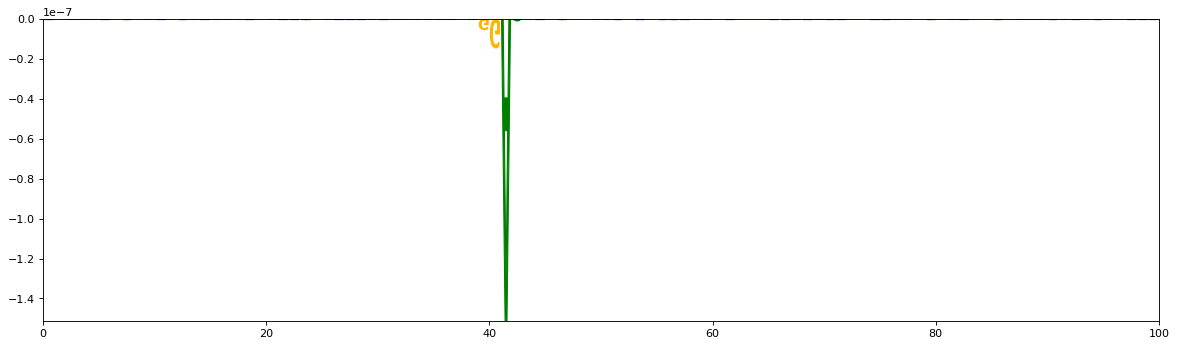

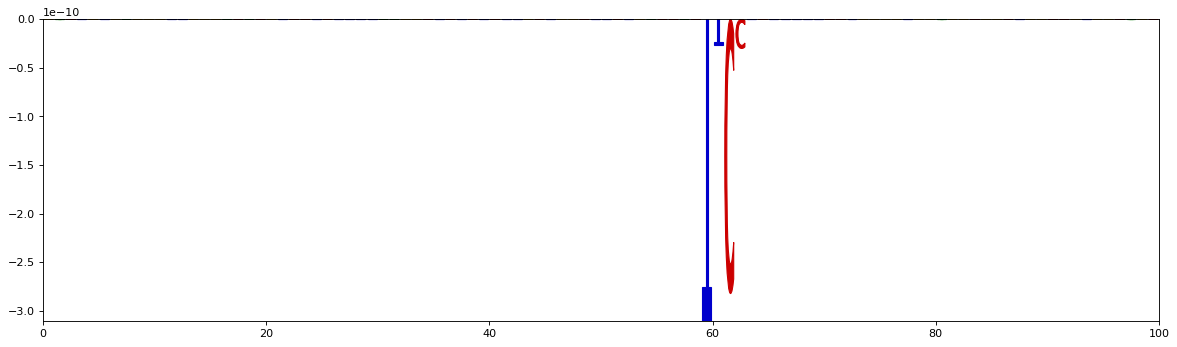

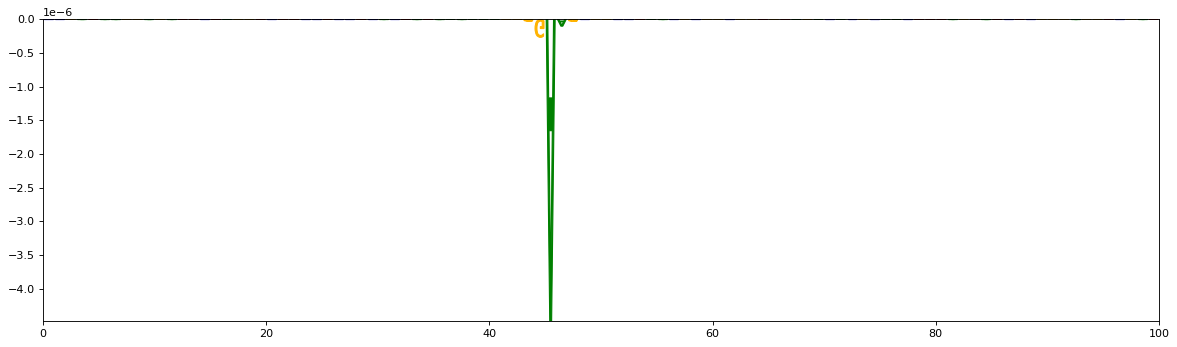

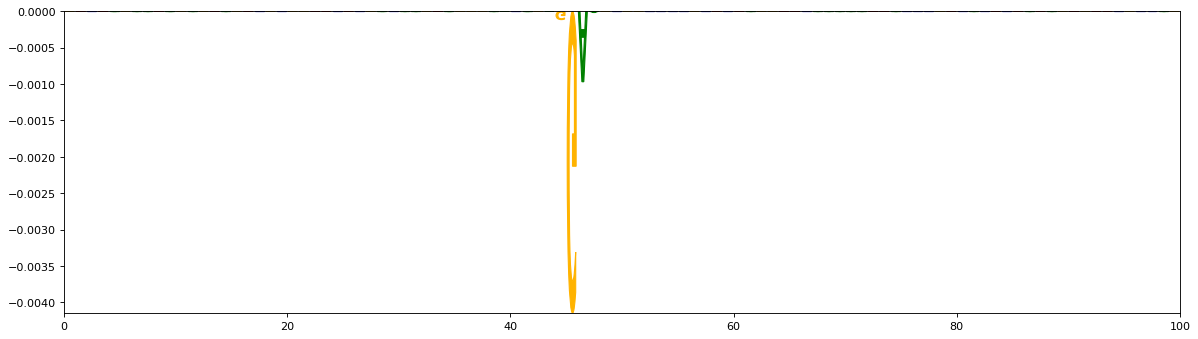

In [30]:
for i in range(n_plot):
    fig = plt.figure(figsize=(18, 5), dpi= 80)
    ax=fig.add_subplot(111)
    plot_sequence_spectrum(ax, X_plot[i].reshape((100, 4)), np.arcsinh(scores[i]).reshape(100,1))
    plt.show()